# Positional Encoding

The self attention mechanism operates on a set of tokens and are naturally permutation invariant. Using a motivating example of the phrase, "the dog chased another dog". Here dog are 2 entirely different entities in the sentence with the same spelling.

In [1]:
import torch
import torch.nn as nn
import tiktoken

# text = "The dog chased another dog"
text = "The dog chased another dog into oblivion until they eventually met in another dimension."
tokenizer = tiktoken.get_encoding("gpt2")
encodedText = torch.tensor(tokenizer.encode(text))
print(f"{text} -> {encodedText}")

embedDims = 128
wEmbed = nn.Embedding(tokenizer.max_token_value, embedDims)
embeddedText = wEmbed(encodedText)
print(f"{text} -> Embedded tensor of shape {embeddedText.shape}")

The dog chased another dog into oblivion until they eventually met in another dimension. -> tensor([  464,  3290, 26172,  1194,  3290,   656,   909, 26018,  1566,   484,
         4191,  1138,   287,  1194, 15793,    13])
The dog chased another dog into oblivion until they eventually met in another dimension. -> Embedded tensor of shape torch.Size([16, 128])


In [2]:
wQ = nn.Linear(embedDims, embedDims, bias=False)
wK = nn.Linear(embedDims, embedDims, bias=False)
wV = nn.Linear(embedDims, embedDims, bias=False)

mha = nn.MultiheadAttention(embed_dim=embedDims, num_heads=4, batch_first=False)
with torch.no_grad():
    for param in mha.parameters():
        nn.init.normal_(param, std=0.1)

torch.Size([16, 128])
torch.Size([16, 16])


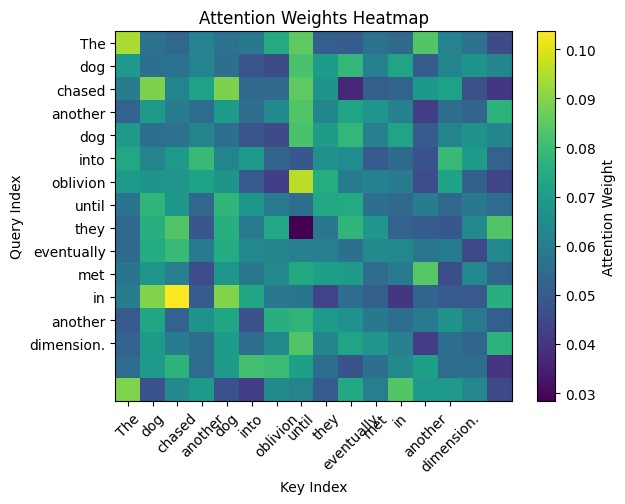

In [3]:
with torch.no_grad():
    attnOutput, attnWeights = mha(wQ(embeddedText), wK(embeddedText), wV(embeddedText))
print(attnOutput.shape)
print(attnWeights.shape)

import matplotlib.pyplot as plt

plt.imshow(attnWeights.detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xlabel('Key Index')
plt.ylabel('Query Index')
plt.title('Attention Weights Heatmap')
plt.xticks(ticks=range(len(text.split())), labels=text.split(), rotation=45)
plt.yticks(ticks=range(len(text.split())), labels=text.split())
plt.show()

As you can see from the above attention heatmap, the columns 1 and 4 for "dog" are both the same because the term "dog" taken as a single out of context word has the same embedding and dot products regardless of where or when the operation was performed.

In [4]:
dog1 = attnOutput[1, :]
dog2 = attnOutput[4, :]
print(f"Attention outputs for both 'dog' entries are close: {torch.allclose(dog1, dog2, atol=1e-6)}")

dog1 = attnWeights[1, :]
dog2 = attnWeights[4, :]
print(f"Attention weights for both 'dog' entries are close: {torch.allclose(dog1, dog2, atol=1e-6)}")

Attention outputs for both 'dog' entries are close: True
Attention weights for both 'dog' entries are close: True


From an english speaker's perspective, "dog" in that sentence are completely different but from a maths perspective, they're are the same.
We need a way to encode the concept of a word having a different meaning depending on it's position in a sequence and this is exactly what **positional encoding** does!.

Positional encoding ensures that the term "dog" in the phrase "dog barks in the night, another dog hears the call, dogs in harmony." would take on an entirely different embedding so that they are treated differently during self attention, just like human languages would associate context to each "dog" occurrence.

## Desirable properties for a positional encoding scheme

1. Unique encoding for each position: A token should have a unique encoding regardless of the sequence length.
2. Linear relation between two encoded positions: It should be easy for the model to learn how a given position $p$, relates to a later position $p+k$. A simple scheme would the number line where it is obvious that 2 ($k$) positions after 3 ($p$) should be the position 5 ($p+k$).
3. It should be independent of the sequence length: This invariance to the sequence length is required so that the scheme can handle lengths outside what it was trained on.
4. The positioning scheme should be deterministic and learnable: related to #2. The model should be able learn how these encoding label position over any sequence length.
5. Support tokens in arbitrary dimensions i.e 1D sequences, 2D sequences or nD sequences: This is aimed at multi-modal models like Vision LLMs that can handle text and images sequences.

## Some position encoding schemes
### Integer position encoding
For each integer position of the token, this gets added to the values of the token.

<video alt="IntegerEncoding.mp4" autoplay="" loop="" autobuffer="" muted="" playsinline="">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/IntegerEncoding.mp4" type="video/mp4">
  </video>


torch.Size([16, 128])
tensor([-0.0609,  0.9306,  2.0041,  3.0232,  3.9306,  5.1182,  6.0202,  7.0212,
         8.0195,  8.9407, 10.0383, 11.0784, 12.0613, 13.0232, 14.0253, 14.9285],
       grad_fn=<MeanBackward1>)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])


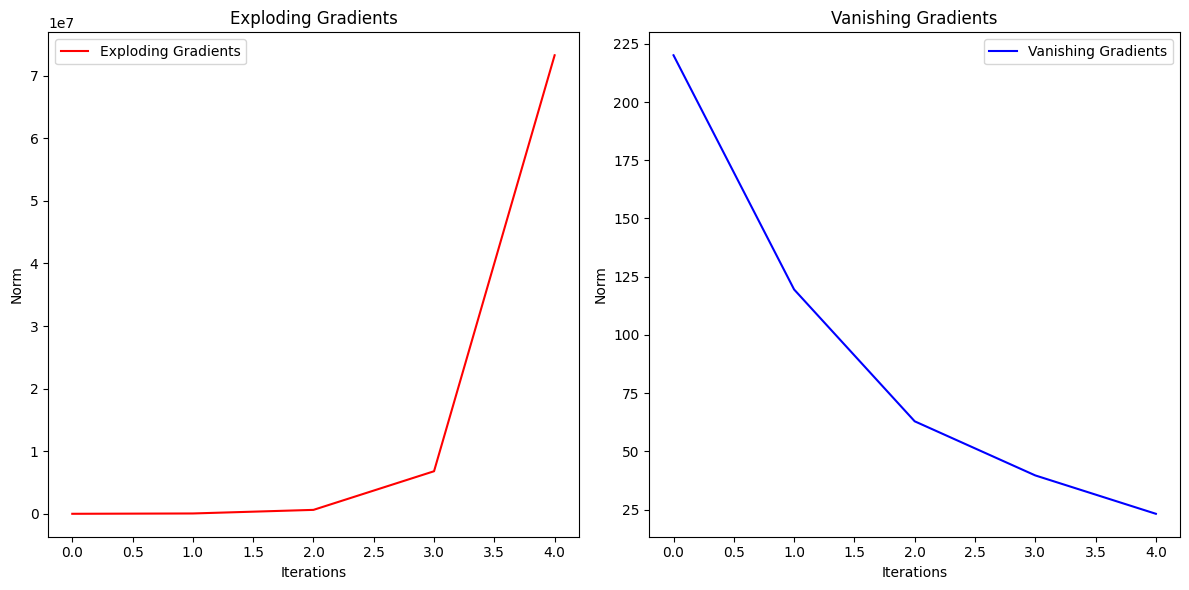

In [5]:
print(embeddedText.shape)
indexPositions = torch.arange(embeddedText.shape[0]).unsqueeze(1) # (5,1)
# Unsqueeze indexPositions to match the dimensions of embeddedText
positionalEncoding = embeddedText + indexPositions

row_means = positionalEncoding.mean(dim=1)
print(row_means)
print(indexPositions.squeeze())

exploding = []
vanishing = []
with torch.no_grad():
    p = positionalEncoding
    for _ in range(5):
        p = p @ torch.randn(128, 128)
        exploding.append(p.norm())

    p = positionalEncoding
    for _ in range(5):
        p = wQ(p)
        vanishing.append(p.norm())

plt.figure(figsize=(12, 6))

# Plot exploding gradients
plt.subplot(1, 2, 1)
plt.plot(exploding, label='Exploding Gradients', color='red')
plt.title('Exploding Gradients')
plt.xlabel('Iterations')
plt.ylabel('Norm')
plt.legend()

# Plot vanishing gradients
plt.subplot(1, 2, 2)
plt.plot(vanishing, label='Vanishing Gradients', color='blue')
plt.title('Vanishing Gradients')
plt.xlabel('Iterations')
plt.ylabel('Norm')
plt.legend()

plt.tight_layout()
plt.show()
        

In the above example, the final `positionalEncoding` have means that are similar to the index positions used in `indexPositions`.

This would obviously result in large values for long sequences which can lead to exploding gradients as illustrated. An obvious attempt would be to normalise it by the total tokens in the sequence as shown below.
However, this would violate the first requirement #1, as for example $0.8$ could be added to the token value at either the 5th position or the 100th position, and would depend heavily on the sequence length, which is not a desirable property - As #1 states that the encoded position should not depend on the sequence length.

In [6]:
indexPositions = torch.arange(embeddedText.shape[0]).unsqueeze(1) / embeddedText.shape[0] # (5,1)
# Unsqueeze indexPositions to match the dimensions of embeddedText
positionalEncoding = embeddedText + indexPositions

row_means = positionalEncoding.mean(dim=1)
print(row_means)
print(indexPositions.squeeze())

tensor([-0.0609, -0.0069,  0.1291,  0.2107,  0.1806,  0.4307,  0.3952,  0.4587,
         0.5195,  0.5032,  0.6633,  0.7659,  0.8113,  0.8357,  0.9003,  0.8660],
       grad_fn=<MeanBackward1>)
tensor([0.0000, 0.0625, 0.1250, 0.1875, 0.2500, 0.3125, 0.3750, 0.4375, 0.5000,
        0.5625, 0.6250, 0.6875, 0.7500, 0.8125, 0.8750, 0.9375])


### Binary position encoding

This is another valid scheme where the index positions are converted to their binary representation and added to the token values. 
This approach addresses the issues encountered with integer encoding by providing a more structured representation. However, it introduces a significant challenge: 
dimension mismatch. While this encoding can support arbitrary sequences, it does not inherently solve the problem of aligning the binary representation with the 
embedding dimension, which remains a critical limitation.

#### A simple pattern with binary numbers
```
0:  0 0 0 0    8:  1 0 0 0  
1:  0 0 0 1    9:  1 0 0 1  
2:  0 0 1 0    10: 1 0 1 0  
3:  0 0 1 1    11: 1 0 1 1  
4:  0 1 0 0    12: 1 1 0 0  
5:  0 1 0 1    13: 1 1 0 1  
6:  0 1 1 0    14: 1 1 1 0  
7:  0 1 1 1    15: 1 1 1 1  
```
* The rightmost bit (Least Significant Bit) alternates with every number
* The second bit from the right alternates every two numbers 
* The third bit alternates every four numbers 
* The 4th bit alternates every 8 numbers
And this would keep doubling as the significant bit shifts to the left. Oddly enough, this matches the requirements for a positional encoding scheme -- If only there was a way to translate this binary pattern to arbitrary vector lengths.

<video alt="BinaryEncoding.mp4" autoplay="" loop="" autobuffer="" muted="" playsinline="" style="display: flex; flex-direction: row; align-items: center; text-align: center; margin: 0; width: 50%;">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/BinaryEncoding.mp4" type="video/mp4">
  </video>

<video alt="BinaryPositionalEncodingPlot.mp4" autoplay="" loop="" autobuffer="" muted="" playsinline="" style="display: flex; flex-direction: row; align-items: center; text-align: center; margin: 0; width: 50%;">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/BinaryPositionalEncodingPlot.mp4" type="video/mp4">
  </video>

The binary encoding mechanism also results in discrete discontinuous values for each token which is not optimisation friendly
<video alt="BinaryVector3D.mp4" autoplay="" loop="" autobuffer="" muted="" playsinline="" style="display: flex; flex-direction: row; align-items: center; text-align: center; margin: 0; width: 50%;">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/BinaryVector3D.mp4" type="video/mp4">
  </video>

## Sinusoidal position encoding

<figure style="display: flex; flex-direction: row; align-items: center; text-align: center; margin: 0; width: 50%;">
  <video alt="SteppedPositionalEncodingPlot.mp4" autoplay="" loop="" autobuffer="" muted="" playsinline="">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/SteppedPositionalEncodingPlot.mp4" type="video/mp4">
  </video>
  <figcaption></figcaption>
</figure>

The authors wrote their function that generates frequency values that decay at the same rate regardless of the sequence length using the formula

$$
\omega_i = \frac{1}{10,000^{\frac{2i}{d}}}
$$

The base value of $10,000$ was chosen through experimentation. All it does is simply control the rate at which the plot decays, you can try this with different values of $10$, $100$, $1000$, $10000$ to see how it decays.

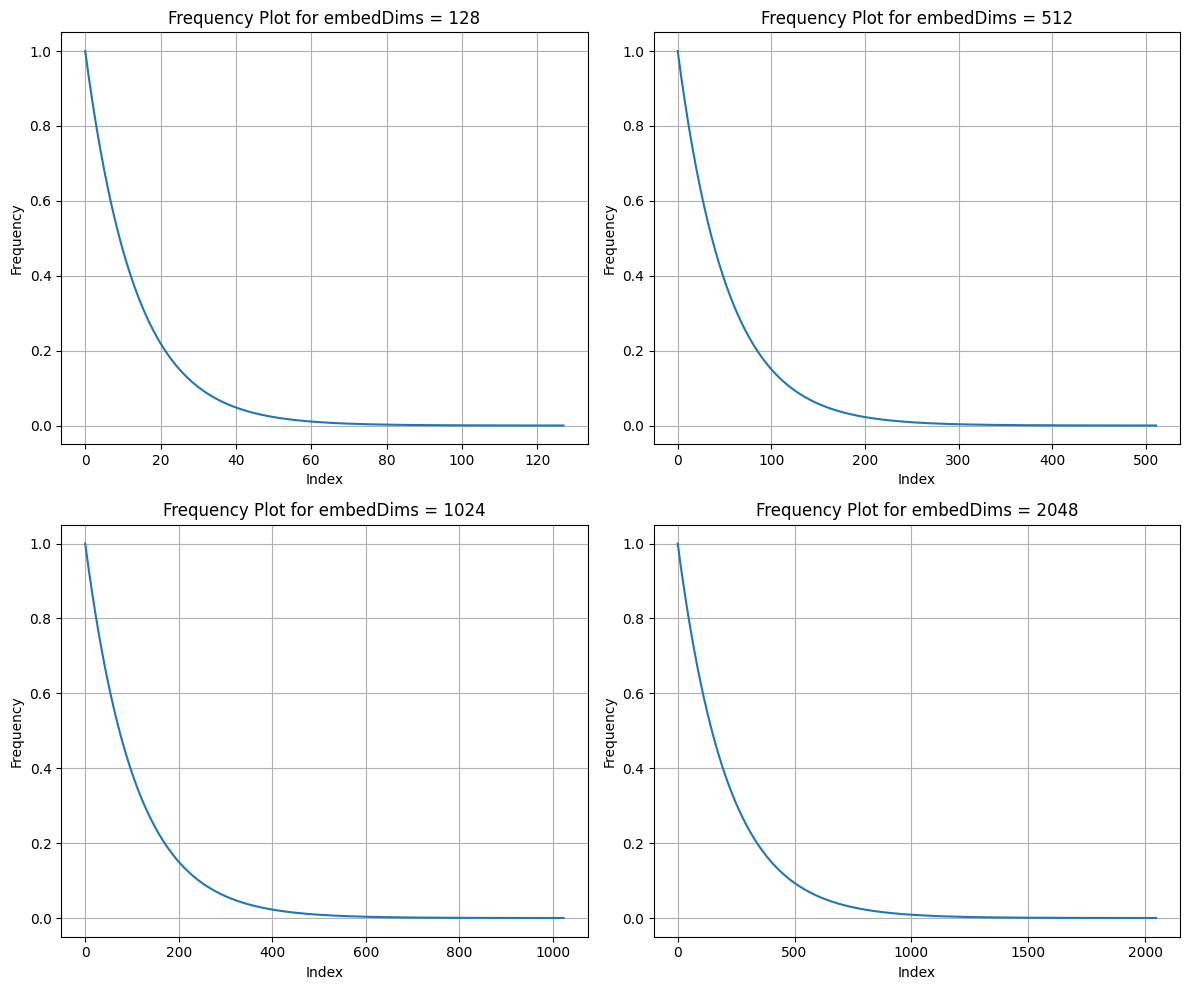

In [7]:
import ipywidgets as widgets
from ipywidgets import interact

def plot_frequency(baseWaveLength):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots
    axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

    for i, embedDims in enumerate(embedDims_values):
        embedDimsIdx = torch.arange(0, embedDims)
        p = (2 * embedDimsIdx) / embedDims
        waveLength = torch.tensor(baseWaveLength)
        den = waveLength**p
        freq = 1 / den

        axes[i].plot(freq)
        axes[i].set_title(f'Frequency Plot for embedDims = {embedDims}')
        axes[i].set_xlabel('Index')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


embedDims_values = [128, 512, 1024, 2048]
plot_frequency(128)

In [8]:
# Create an interactive slider for baseWaveLength
interact(plot_frequency, baseWaveLength=widgets.IntSlider(min=5, max=10000, step=100, value=10000));

interactive(children=(IntSlider(value=10000, description='baseWaveLength', max=10000, min=5, step=100), Output…

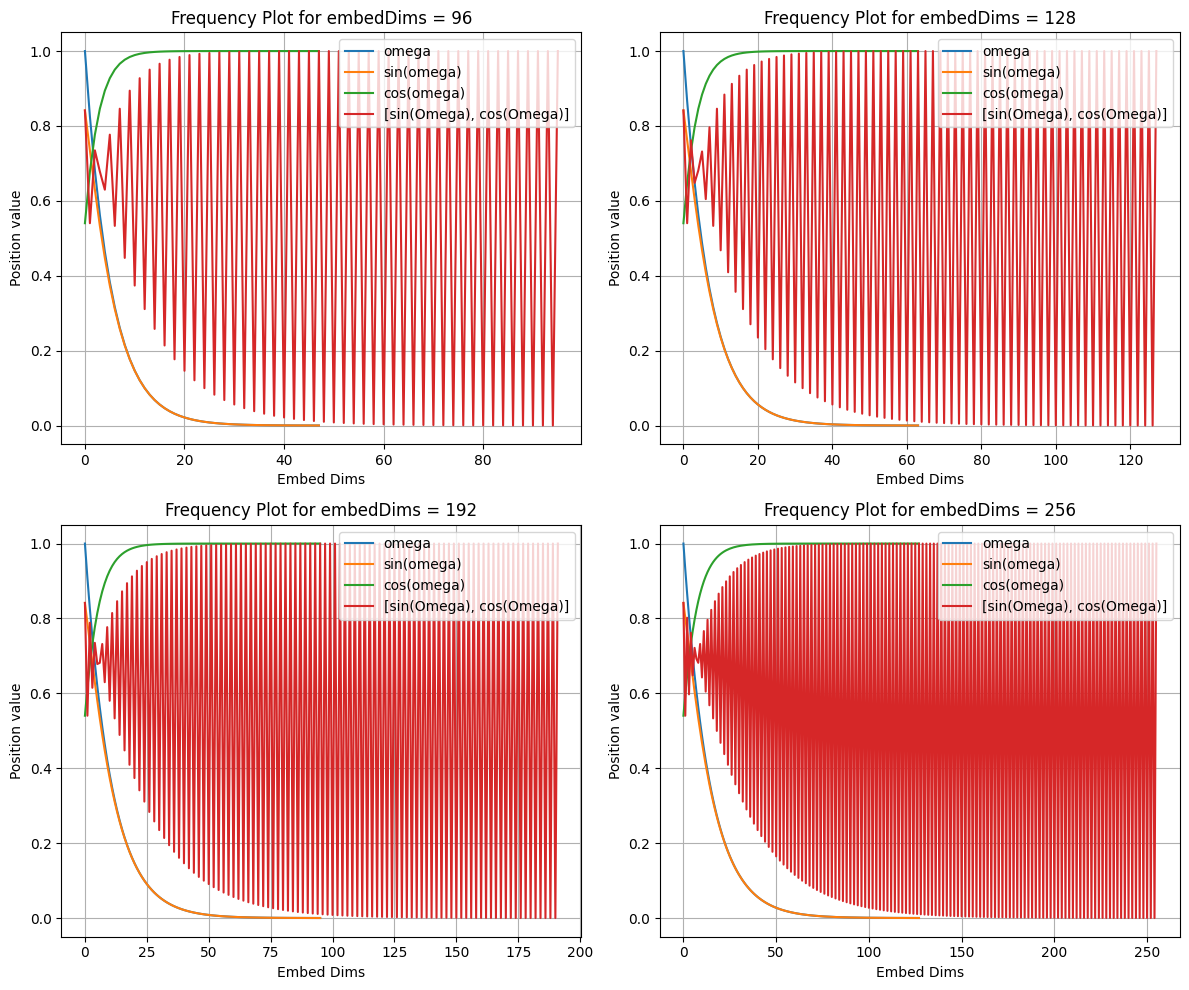

In [9]:
embedDimsToUse = [96, 128, 192, 256]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
for i, embedDims in enumerate(embedDimsToUse):    
    positions = torch.arange(encodedText.numel()).unsqueeze(1)  # Shape: (N, 1)

    # Compute frequency for each dimension
    pos = torch.arange(embedDims // 2)  # Half of the dimensions (because we pair sin and cos)
    omega = 1 / (10000 ** (2 * pos / embedDims))  # Shape: (d/2,)
    
    axes[i].plot(omega, label='omega')
    axes[i].plot(torch.sin(omega), label='sin(omega)')
    axes[i].plot(torch.cos(omega), label='cos(omega)')
    xs = torch.zeros(1, embedDims)
    xs[0, 0::2] = torch.sin(omega)
    xs[0, 1::2] = torch.cos(omega)
    axes[i].plot(xs.squeeze(), label='[sin(Omega), cos(Omega)]')
    axes[i].legend(loc='upper right')
    axes[i].set_title(f'Frequency Plot for embedDims = {embedDims}')
    axes[i].set_xlabel('Embed Dims')
    axes[i].set_ylabel('Position value')
    axes[i].grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


The resulting sinusoidal postitions would be a set of consecutive pairs of sines and cosines for each frequency. The frequencies are determined by the authors to span half the length of the tokens to be encoded.

$$
\mathbf{p_t} = 
\begin{bmatrix}
\sin(\omega_1 t) \\ 
\cos(\omega_1 t) \\
\\
\sin(\omega_2 t) \\ 
\cos(\omega_2 t) \\
\\
\vdots \\
\\
\sin(\omega_{\frac{d}{2}} t) \\ 
\cos(\omega_{\frac{d}{2}} t) \\
\end{bmatrix}_{d \times 1}
$$

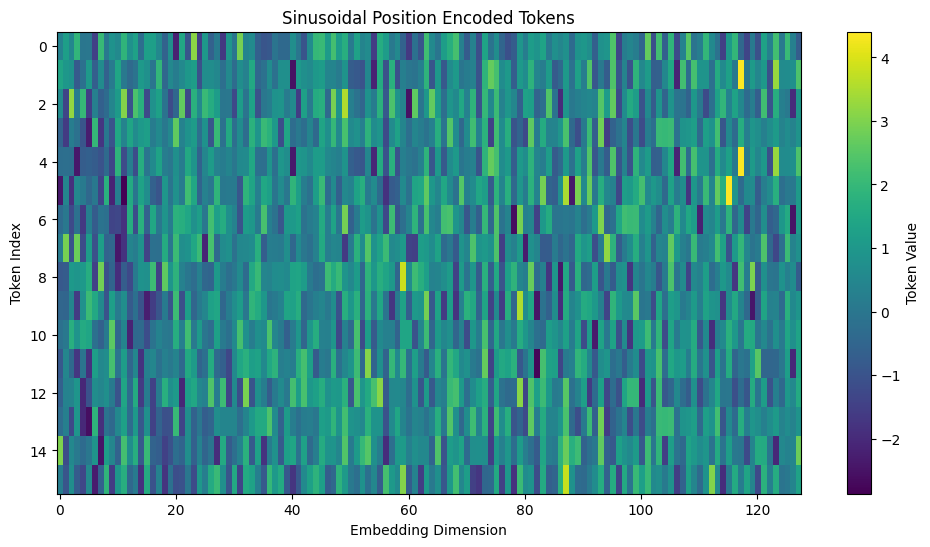

In [10]:
# Compute the sinusoidal encoding
embedDims = 128 # reset it back to the original amount
positions = torch.arange(encodedText.numel()).unsqueeze(1)  # Shape: (N, 1)
# Compute frequency for each dimension
pos = torch.arange(embedDims // 2)  # Half of the dimensions (because we pair sin and cos)
omega = 1 / (10000 ** (2 * pos / embedDims))  # Shape: (d/2,)

positionalEncoding = torch.zeros((encodedText.numel(), embedDims))
positionalEncoding[:, 0::2] = torch.sin(positions * omega)  # Apply sin to even indices
positionalEncoding[:, 1::2] = torch.cos(positions * omega)  # Apply cos to odd indices

tokensPositionEncoded = embeddedText + positionalEncoding  # Element-wise addition

# Visualize the position encoded tokens
plt.figure(figsize=(12, 6))
plt.imshow(tokensPositionEncoded.detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Token Value')
plt.xlabel('Embedding Dimension')
plt.ylabel('Token Index')
plt.title('Sinusoidal Position Encoded Tokens')
plt.show()

### Relative distance between positions

Vectors in the same direction when multiplied together would have a higher value and a lower value, the more they point in opposite directions.
As a result, we can build a similarity matrix that shows how tokens near each other are in the same direction and are in a different direction to tokens
further away.

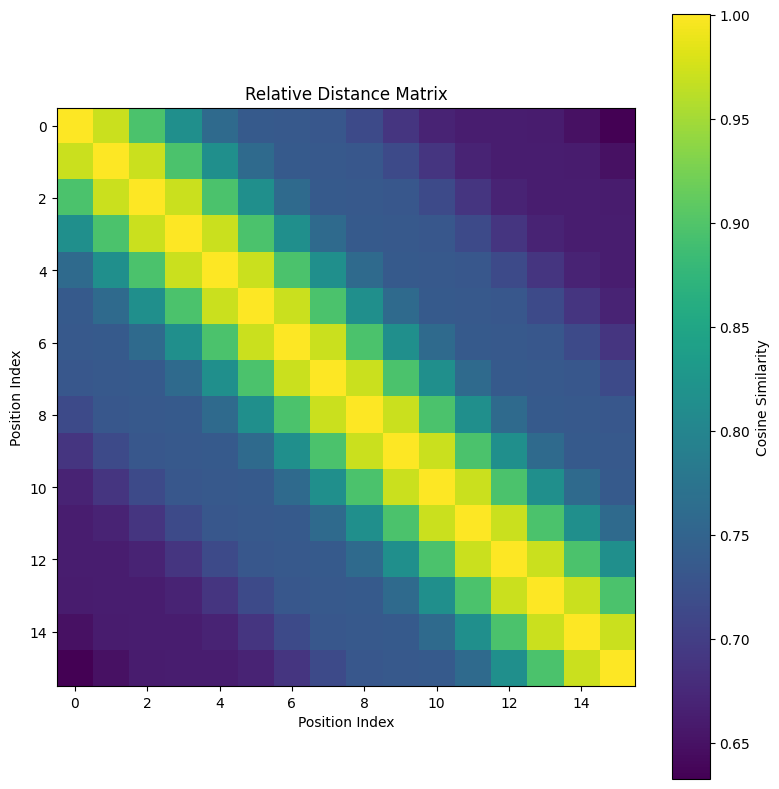

In [11]:
import torch.nn.functional as F
# Normalize to unit vectors
nPositionalEncoding = F.normalize(positionalEncoding, p=2, dim=1)  # Shape: (seq_len, d)

# Compute cosine similarity matrix using matrix multiplication
similarityMatrix = nPositionalEncoding @ nPositionalEncoding.T  # Shape: (seq_len, seq_len)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(similarityMatrix.numpy(), cmap="viridis", interpolation="nearest")
plt.colorbar(label="Cosine Similarity")
plt.title("Relative Distance Matrix")
plt.xlabel("Position Index")
plt.ylabel("Position Index")
plt.tight_layout()
plt.show()

## Rotary position encoding (RoPE)

Reflecting back on the definition of a dot product as 

$$\vec{a} \cdot \vec{b} = |\vec{a}| |\vec{b}| cos \theta$$

If we want the resulting dot product to be a high value, we need both vectors to be in the same direction i.e the angle $\theta$ between 
needs to be low.
One way to achieve this is to simply rotate one of the vectors in the direction of the other and luckily rotating a vector has no 
implications on it magnitude (which encodes the semantic information of the token).

To illustrate this, the norm of the tokens are printed before and after the sinusoidal position encoding are added and it's clear that there
is a slight increase in the norm after addition.


In [12]:
print(embeddedText.norm())
print(tokensPositionEncoded.norm())

tensor(44.1197, grad_fn=<LinalgVectorNormBackward0>)
tensor(54.8577, grad_fn=<LinalgVectorNormBackward0>)


One of the core ideas behind Rotary Positional Encoding (referred to as RoPE onwards) is that we can simply rotate the queries $\bf{q}$ and keys $\bf{k}$ to encode their _relative_ position, rather than rotating their pre-projection $\bf{x}$.
> Remember, this rotation does not change the magnitude of the vector

This is applied to both the queries and the keys before attention. The resulting rotation is gotten by 

$$
R(q) = K \cdot \vec{q} 
$$

where $K \in \reals^{d \times d}$, $\vec{q} \in \reals^{d\times1}$ and $d$ is the dimension of the embedding.

$K$ is a diagonal matrix containing that rotates consecutive pairs in $\vec{q}$. The full operation of $R(q)$ is illustrated below
$$
R(q) = 
\begin{bmatrix}
M_1 & & & \\
    & M_2 & & \\
    &     & \ddots & \\
    &   &   & M_{\frac{d}{2}}
\end{bmatrix}

\begin{bmatrix}
q_1 \\
q_2 \\
\vdots \\
q_d
\end{bmatrix}
$$

where each entry $M_i$ is given by the rotation matrix, similar to the sinusoidal encoding but with an **important difference**. This 
matrix is formed from a counter-clockwise rotation while the sinusoidal encoding uses a clockwise rotation (_I don't think this makes that much of a difference in the long run but it's best to stick with the original implementation in the paper_).

$$
M_i = 
\begin{bmatrix}
\cos(\omega_i p)  & -\sin(\omega_i p) \\
\sin(\omega_i p)  &  \cos(\omega_i p)
\end{bmatrix}
$$

> NB: $p$ marks the ith-position in the embedding dimension and not a constant

While this is easy to compute via matrix multiplication, it would be inefficient due to the compute due to the sparsity of $K$.
We can instead, partially solve the multiplication to obtain whole forms as follows. For example, lets take the multiplication between 
$M_1$ and elements $q_1, q_2$. 

$$
\begin{gather}
M_i \cdot \begin{bmatrix} q_1 \\ q_2 \end{bmatrix} \\

=
\begin{bmatrix}
\cos(\omega_1 p)  & -\sin(\omega_1 p) \\
\sin(\omega_1 p)  &  \cos(\omega_1 p)
\end{bmatrix}
\begin{bmatrix} q_1 \\ q_2 \end{bmatrix}
\\

=
\begin{bmatrix}
q_1\cos(\omega_1 p)  & -q_2\sin(\omega_1 p) \\
q_1\sin(\omega_1 p)  &  q_2\cos(\omega_1 p)
\end{bmatrix}

\end{gather}
$$

which we can deconstruct into element-wise operations by grouping and re-arranging the operations involving cos and sin as

$$
=
\begin{bmatrix} q_1 \\ q_2 \end{bmatrix}
\circ
\begin{bmatrix} \cos(\omega_1 p) \\ \cos(\omega_1 p) \end{bmatrix}
+
\begin{bmatrix} -q_2 \\ q_1 \end{bmatrix}
\circ
\begin{bmatrix} \sin(\omega_1 p) \\ \sin(\omega_1 p) \end{bmatrix}
$$

And by extending it to a few more cases, we can see a pattern emerge, that should make this easier to compute in PyTorch

$$
\begin{bmatrix} q_1 \\ q_2 \\ q_3 \\ q_4 \\ \vdots \\ q_{d-1} \\ q_d \end{bmatrix}
\circ
\begin{bmatrix} 
    \cos(\omega_1 p) \\ \cos(\omega_1 p) \\
    \cos(\omega_2 p) \\ \cos(\omega_2 p) \\
    \vdots \\
    \cos(\omega_{d/2} p) \\ \cos(\omega_{d/2} p) \\
\end{bmatrix}
+
\begin{bmatrix} -q_2 \\ q_1 \\ -q_4 \\ q_3 \\ \vdots \\ -q_{d} \\ q_{d-1} \end{bmatrix}
\circ
\begin{bmatrix} 
    \sin(\omega_1 p) \\ \sin(\omega_1 p) \\
    \sin(\omega_2 p) \\ \sin(\omega_2 p) \\
    \vdots \\
    \sin(\omega_{d/2} p) \\ \sin(\omega_{d/2} p) \\
\end{bmatrix}
$$

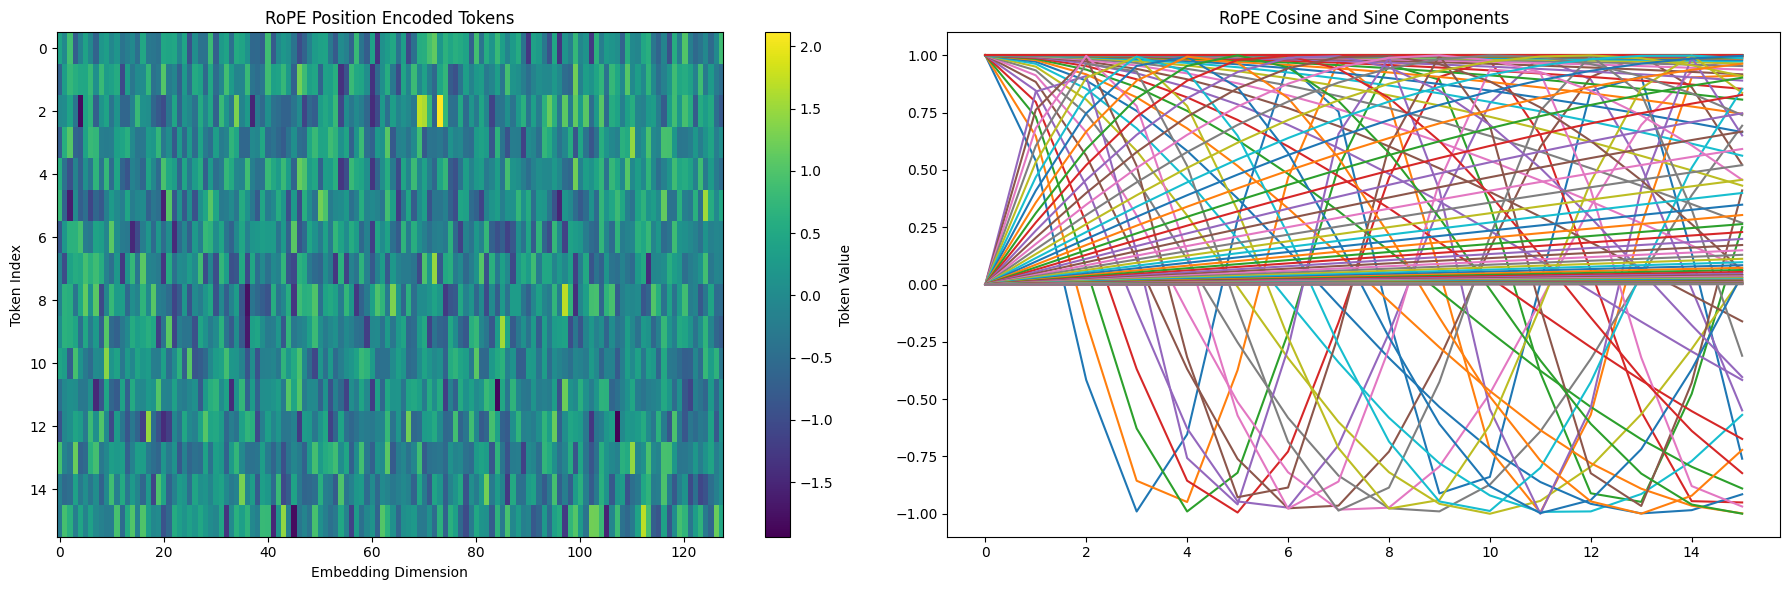

In [20]:
q = wQ(embeddedText)

# Compute the RoPE encoding
embedDims = 128 # reset it back to the original amount
positions = torch.arange(encodedText.numel()).unsqueeze(1)  # Shape: (N, 1)
# Compute frequency for each dimension
pos = torch.arange(embedDims // 2)  # Half of the dimensions (because we pair sin and cos)
omega = 1 / (10000 ** (2 * pos / embedDims))  # Shape: (d/2,)

cos_part = torch.cos(positions * omega)
sin_part = torch.sin(positions * omega)

# Apply RoPE to q
q_rotated = torch.zeros_like(q)
q_rotated[:, 0::2] = q[:, 0::2] * cos_part - q[:, 1::2] * sin_part
q_rotated[:, 1::2] = q[:, 1::2] * cos_part + q[:, 0::2] * sin_part

# Assign the rotated q as the position-encoded tokens
# NB: In practice, this should be applied to the queries and keys, not the text embeddings
tokensPositionEncoded = q_rotated

# Visualize the position encoded tokens and RoPE components side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot RoPE Position Encoded Tokens
im0 = axes[0].imshow(tokensPositionEncoded.detach().numpy(), cmap='viridis', aspect='auto')
axes[0].set_title('RoPE Position Encoded Tokens')
axes[0].set_xlabel('Embedding Dimension')
axes[0].set_ylabel('Token Index')
fig.colorbar(im0, ax=axes[0], label='Token Value')

# Plot RoPE Cosine and Sine Components
axes[1].plot(cos_part.numpy(), label='cos_part')
axes[1].plot(sin_part.numpy(), label='sin_part')
axes[1].set_title('RoPE Cosine and Sine Components')

plt.tight_layout()
plt.show()

Visually, it's hard to see the difference between the RoPE and sinusoidal positions, however, we can see that the norms are lower after RoPE which is desirable compared to the sinusoidal positioning.

In [14]:
print(embeddedText.norm())
print(tokensPositionEncoded.norm())

tensor(44.1197, grad_fn=<LinalgVectorNormBackward0>)
tensor(25.7709, grad_fn=<LinalgVectorNormBackward0>)


> One of the main takeaways from sinusoidal and rotational position encoding is to think of the embedding values as a sequence of consecutive (x,y) values that would be rotated. It is conter-intuitive but the beatuy of embeddings is that backpropagation would optimise for this and compute gradients that shape the embeddings into this representation.

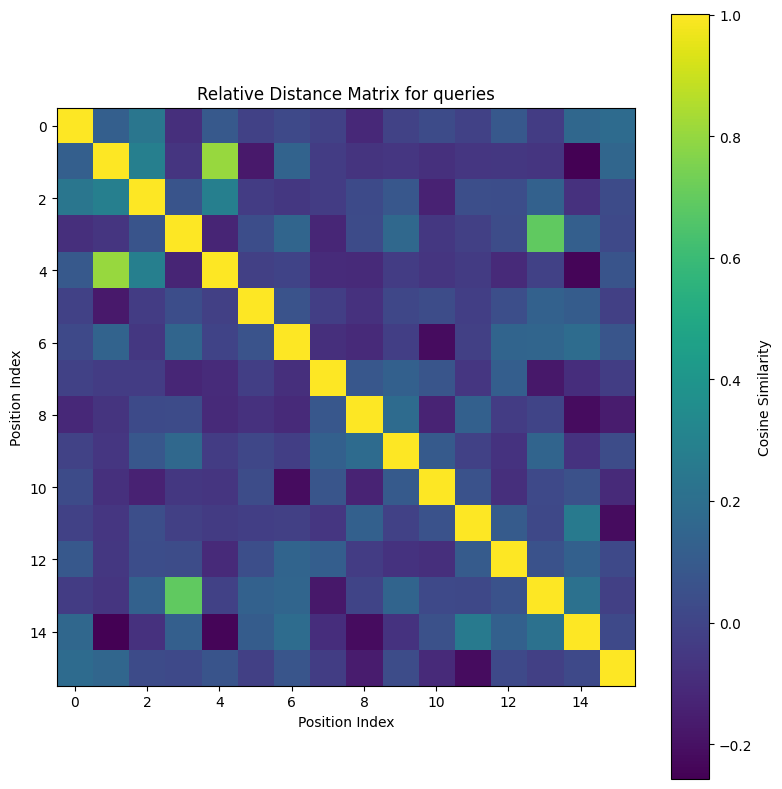

In [15]:
# Normalize to unit vectors
nQRotated = F.normalize(tokensPositionEncoded, p=2, dim=1)  # Shape: (seq_len, d)

# Compute cosine similarity matrix using matrix multiplication
similarityMatrix = nQRotated @ nQRotated.T  # Shape: (seq_len, seq_len)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(similarityMatrix.detach().numpy(), cmap="viridis", interpolation="nearest")
plt.colorbar(label="Cosine Similarity")
plt.title("Relative Distance Matrix for queries")
plt.xlabel("Position Index")
plt.ylabel("Position Index")
plt.tight_layout()
plt.show()

# References

* https://huggingface.co/blog/designing-positional-encoding
* https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/ 
* https://medium.com/thedeephub/positional-encoding-explained-a-deep-dive-into-transformer-pe-65cfe8cfe10b 